In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import StatevectorSimulator

![alt text](image.png)

In [2]:
def oracle(b: str):
    # oracle |x>|0> -> |x>|f> for f where f(x) = f(y) iff x = y ^ b (x^y=b)
    """returns a Simon oracle for bitstring b"""
    b = b[::-1] # reverse b for easy iteration
    n = len(b)
    qc = QuantumCircuit(n*2)
    # Do copy; |x>|0> -> |x>|x>
    for q in range(n):
        qc.cx(q, q+n)

    if '1' not in b: 
        return qc  # 1:1 mapping, so just exit
    
    i = b.find('1') # index of first non-zero bit in b 
    # actually any i with b[i] = 1 works, bc it divides domain into 2 equal parts.
    # Do |x> -> |s.x> on condition that q_i is 1
    for q in range(n):
        if b[q] == '1':
            qc.cx(i, (q)+n)
    return qc 

In [3]:
so = oracle('10')

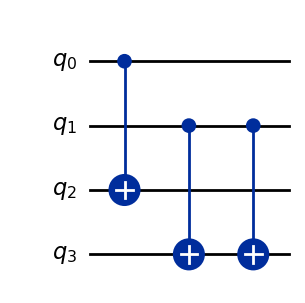

In [4]:
so.draw(output='mpl')

In [5]:
def pre_oracle_qc(oracle: QuantumCircuit):
    qubits = oracle.qubits
    n = int(len(qubits)/2)
    pre_oracle_qc = QuantumCircuit(qubits)
    pre_oracle_qc.h(range(n))
    return pre_oracle_qc


def post_oracle_qc(oracle: QuantumCircuit):
    qubits = oracle.qubits
    n = int(len(qubits)/2)

    post_oracle_qc = QuantumCircuit(qubits, ClassicalRegister(n))
    post_oracle_qc.h(range(n))
    post_oracle_qc.measure(range(n),range(n))
    return post_oracle_qc


In [6]:
def simon(oracle: QuantumCircuit):
    oracle.barrier()
    pre = pre_oracle_qc(oracle)
    pre.barrier()
    post = post_oracle_qc(oracle)
    pre.compose(oracle.compose(post,oracle.qubits), oracle.qubits, inplace=True)
    return pre


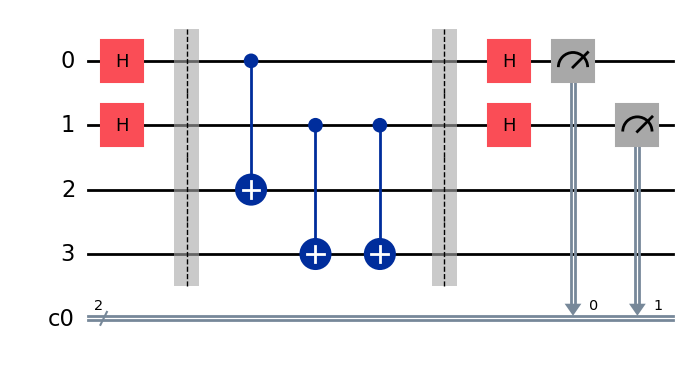

In [7]:
simon_circuit = simon(so)
simon_circuit.draw(output='mpl')

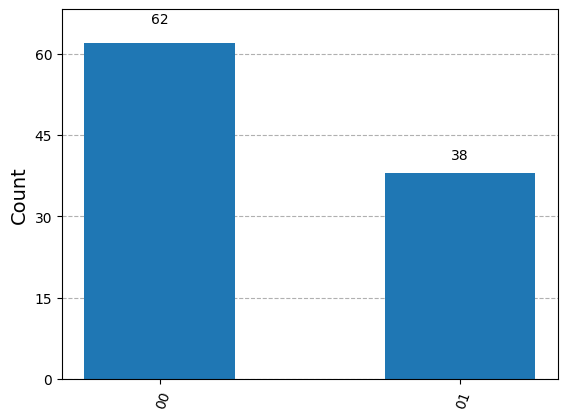

In [8]:
from qiskit.visualization import plot_histogram
backend = StatevectorSimulator()
job = backend.run(simon_circuit,memory=True,shots=100)
result =  job.result()
plot_histogram(result.get_counts())